### Steps to be followed:

* Importing necessary libraries
* Creating s3 bucket
* Importing and exporting the data from git repository and s3 bucket.
* Data preprosessing
* Exploratory data analysis
* Building and deploying the model
* Prediction

## Importing all necessary libraries

In [1]:
# Basic analysis library

import sys
import numpy as np
import pandas as pd

In [2]:
#sagemaker library

import sagemaker                                             #Build in algorithms that are present in sagemaker                                             
import boto3                                                 #Allows to create, update and delete aws resources from s3          
from sagemaker.amazon.amazon_estimator import get_image_uri  #Downloading image container of the models 
from sagemaker.session import s3_input, Session              #Provides convenient methods for manipulating entities and resouces that amazon sagemaker uses, such as training jobs, endpoints and input datasets in s3.
from sagemaker import get_execution_role                     #IAM role created for the instance

In [3]:
# Visualization libraries

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import display
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
%pip install --upgrade boto3   # To avoid getting errors while import or exporting data in s3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 47.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.44
    Uninstalling boto3-1.26.44:
      Successfully uninstalled boto3-1.26.44
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.44 requires botocore==1.29.44, but you have botocore 1.29.66 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.66 which is incompatible.
Note: you may need to restart the kernel to use

### Creating an S3 bucket

The s3 bucket can also be created manually by going to the s3 management console and clicking on create bucket.

In [5]:
bucket_name = 'awsworkshop301' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [6]:
s3 = boto3.resource('s3')  #To get the access of s3 bucket
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


## Data Collection

We are using the diabetes dataset and it is divided into two sections. The first part of the dataset will be imported from git repository and the second part will be imported from the s3 bucket.

#### Importing first part of the data from git repository

In [7]:
data1=pd.read_csv('diabetes_first_data.csv')
data1.head()

,Test ID,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,10248,35,0,33.6,0.627,50,1
1,10249,29,0,26.6,0.351,31,0
2,10250,0,0,23.3,0.672,32,1
3,10251,23,94,28.1,0.167,21,0
4,10252,35,168,43.1,2.288,33,1


#### Importing second part of the data from S3 bucket

In [8]:
#uploading the second data into s3

s3=boto3.resource('s3')
s3.meta.client.upload_file('diabetes_second_data.csv',bucket_name,'diabetes_second_data.csv')

In [9]:
# Loading dataset from s3

role=get_execution_role()
data_key='diabetes_second_data.csv'
data_location = 's3://{}/{}'.format(bucket_name, data_key)

data2=pd.read_csv(data_location)
data2.head()

,Pregnancies,Glucose,Test ID,BloodPressure
0,6,148,10248,72
1,1,85,10249,66
2,8,183,10250,64
3,1,89,10251,66
4,0,137,10252,40


#### Merging the datasets to get a complete data

In [10]:
merge_data=pd.merge(data1,data2, on='Test ID')
merge_data.head()

,Test ID,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies,Glucose,BloodPressure
0,10248,35,0,33.6,0.627,50,1,6,148,72
1,10249,29,0,26.6,0.351,31,0,1,85,66
2,10250,0,0,23.3,0.672,32,1,8,183,64
3,10251,23,94,28.1,0.167,21,0,1,89,66
4,10252,35,168,43.1,2.288,33,1,0,137,40


## Data Preprocessing

In [11]:
#Removing the test id as it is not necessary for exploratory data analysis.

df=merge_data.drop('Test ID', axis='columns')
df.sample(10)

,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies,Glucose,BloodPressure
639,12,46,19.5,0.149,28,0,1,100,74
372,22,66,35.8,0.545,21,0,0,84,64
42,18,0,22.7,0.235,48,0,7,106,92
692,32,95,39.1,0.886,23,0,2,121,70
455,30,0,33.6,0.212,38,1,14,175,62
145,23,0,0.0,0.572,21,0,0,102,75
256,39,0,30.1,0.557,30,0,3,111,56
20,41,235,39.3,0.704,27,0,3,126,88
642,0,0,29.5,0.178,50,1,6,147,80
538,37,210,36.3,0.804,23,0,0,127,80


**'Pregnancies'** is the number of pregnancies to date.

**'Glucose'** is the plasma glucose concentration over 2 hours in an oral glucose tolerance test, measured in milligrams per decilitre (mg/dL). A blood sugar level less than 140 mg/dL is normal. A reading of more than 200 mg/dL indicates diabetes, whereas that between 140 and 199 mg/dL (indicates prediabetes).

**'BloodPressure'** is the diastolic blood pressure, measured in millimeters of mercury (mm Hg). A normal blood pressure would have a reading of less than 80 mmHg, and this may vary from 90 to 120 mmHg for a healthy young person. A reading of more than 140 mmHg indicates high blood pressure.

**'SkinThickness'** is the triceps skin fold thickness, measured in millimeters (mm).

**'Insulin'** is the 2-hour serum insulin, measured in micrometre units per millilitre (mu U/ml).

**'BMI'** is the body mass index (BMI) for weight in kg and height in m (kg/m^2).BMI should not be close to zero unless the person is grossly underweight which could be life-threatening.

**'DiabetesPedigreeFunction'** is a function that scores likelihood of diabetes based on family history, with a realistic range of 0.08 to 2.42.

**'Age'** of a person in years.

**'Outcome'** is the target class label, where 0 represents absence and 1 represents presence of diabetes.

In [12]:

# Displaying the number of entries, the names of the column attributes, the data type and the memory space used

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SkinThickness             768 non-null    int64  
 1   Insulin                   768 non-null    int64  
 2   BMI                       768 non-null    float64
 3   DiabetesPedigreeFunction  768 non-null    float64
 4   Age                       768 non-null    int64  
 5   Outcome                   768 non-null    int64  
 6   Pregnancies               768 non-null    int64  
 7   Glucose                   768 non-null    int64  
 8   BloodPressure             768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


The dataset contains 768 rows of records and 9 columns of attributes. The data types of the attributes consist of 6 quantitative discrete numerical integers and 2 quantitative continuous numerical float values.

In [13]:
# Summary statistics of the attributes, including measures of central tendency and measures of dispersion

ab=df.describe() 
ab

,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies,Glucose,BloodPressure
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958,3.845052,120.894531,69.105469
std,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951,3.369578,31.972618,19.355807
min,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000,1.000000,99.000000,62.000000
50%,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000,3.000000,117.000000,72.000000
75%,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000,6.000000,140.250000,80.000000
max,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000,17.000000,199.000000,122.000000


In [14]:
#Coverting the above table into a dataframe and uploading it into the s3 bucket.

export_dataframe=pd.DataFrame(ab)
describe_key='describe.xlsx'
describe_location='s3://{}/{}'.format(bucket_name, describe_key)
export_dataframe.to_excel(describe_location)

#We can download this file from s3 bucket directly in our local machine.

In [15]:
# Checking for null values 

df.isnull().sum().any()

False

There are no null values in the dataset.

In [16]:
# Checking for duplicate rows

duplicated_rows = df[df.duplicated()]
duplicated_rows.shape

(0, 9)

There are no duplications in the dataset.

Duplicated rows or records will not be dropped from the dataset in this case. There is no certain redundancy which causes inaccurate results and outcomes, since the dataset has no unique identfier that denotes separate entities. Despite this, the dataset will still be checked for duplicated rows.

## Exploratory Data Analysis

EDA aims to perform initial investigations on data before formal modeling and graphical representations and visualisations, in order to discover patterns, look over assumptions, and test hypothesis. The summarised information on main characteristics and hidden trends in data can help the doctor to identify concern areas of problems and the resolution of these can boost their accuracy in diagnosing diabetes.

In [17]:
# Checking the outcome labels

df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

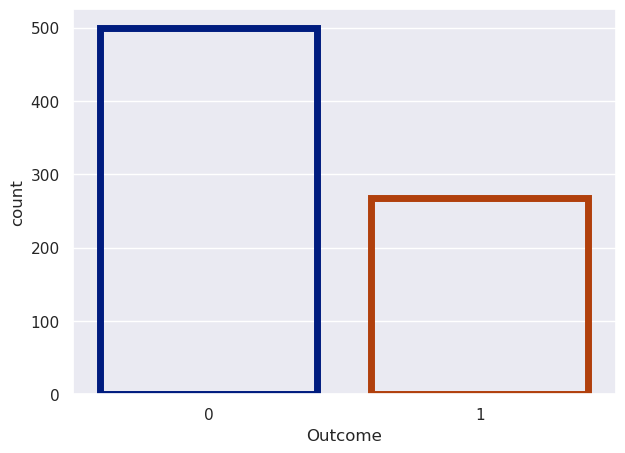

In [18]:
# Plotting the outcome col. histogram

plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='Outcome',palette="autumn",facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))
plt.savefig("countplot.jpg")  #saving the image of this plot in the sagemaker console

In [19]:
#Exporting the image of this plot directly into the s3 bucket

s3=boto3.resource('s3')
s3.meta.client.upload_file('countplot.jpg',bucket_name,'countplot.jpg')

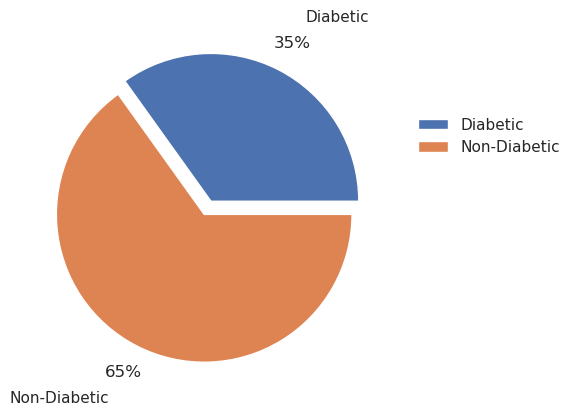

In [20]:
#Creating a piechart to get the percentage of diabetic and non-diabetic population

fig, ax = plt.subplots()

labels = ['Diabetic', 
         'Non-Diabetic']
percentages = [34.89, 65.10]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels, autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.savefig("Piechart.jpg")   #saving the image of this plot in the sagemaker console

In [21]:
#Exporting the image of this plot directly into the s3 bucket

s3=boto3.resource('s3')
s3.meta.client.upload_file('Piechart.jpg',bucket_name,'Piechart.jpg')

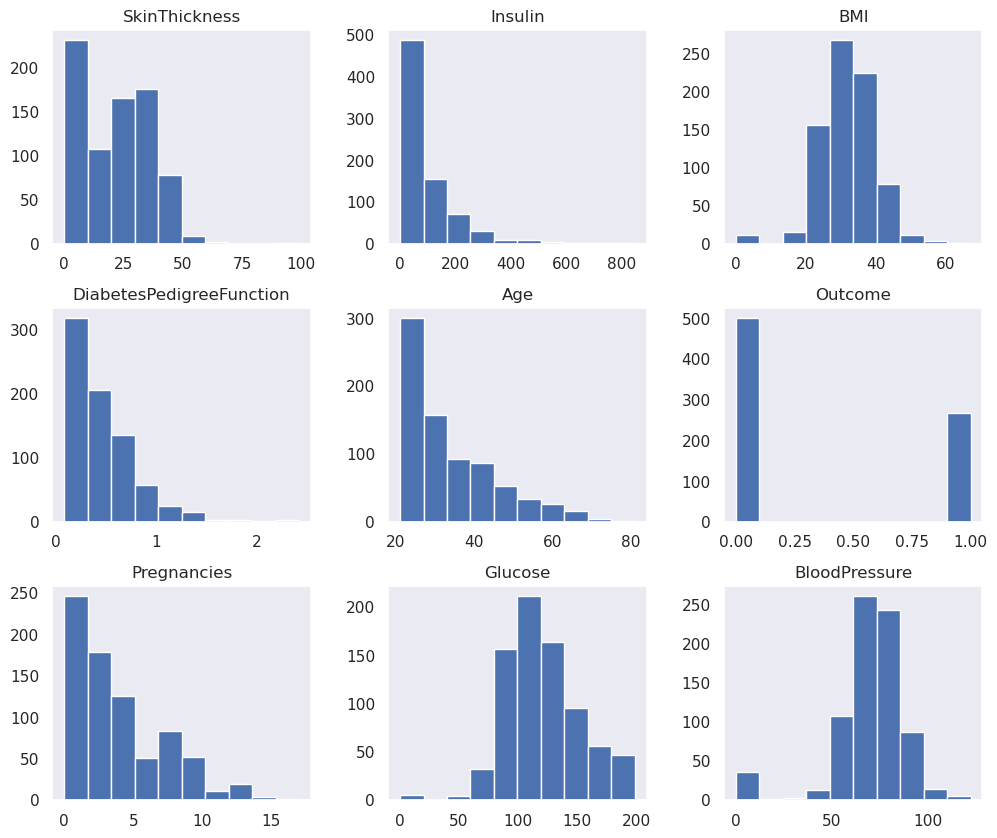

In [22]:
# Checking distribution of all features

df.hist(figsize=(12,10),grid=False)
sns.set_style('white')
plt.savefig("freqdist.jpg")    #saving the image of this plot in the sagemaker console

The Histograms provide us a more or less clear picture that the Attributes are positively skewed.

Furthermore, the histogram density plots and their respective highest point in the curves show the patterns that diabetes patients generally have higher numbers of Pregnancies, higher Glucose and BMI readings, and older in Age.

In [23]:
#Exporting the image of these plots directly into the s3 bucket

s3=boto3.resource('s3')
s3.meta.client.upload_file('freqdist.jpg',bucket_name,'freqdist.jpg')

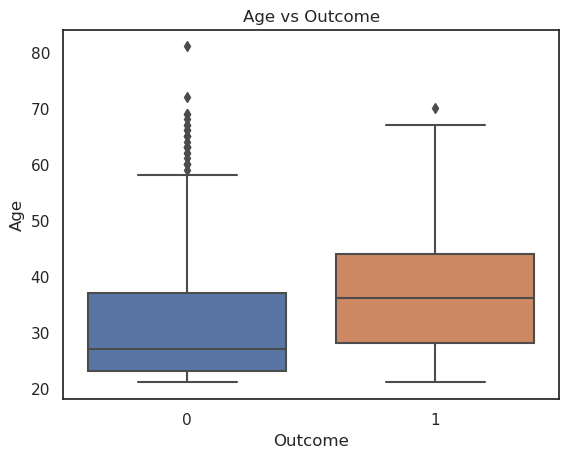

In [24]:
#First, we would know what is the effect of Age on the Outcome because we have heard that as the age increases, the chances of diabetes also commonly increases.

sns.boxplot(x = 'Outcome', y = 'Age', data = df)
plt.title('Age vs Outcome')
plt.show()

Yes, we were right, the median of the age of diabetic people is greater than that of non-diabetic people.

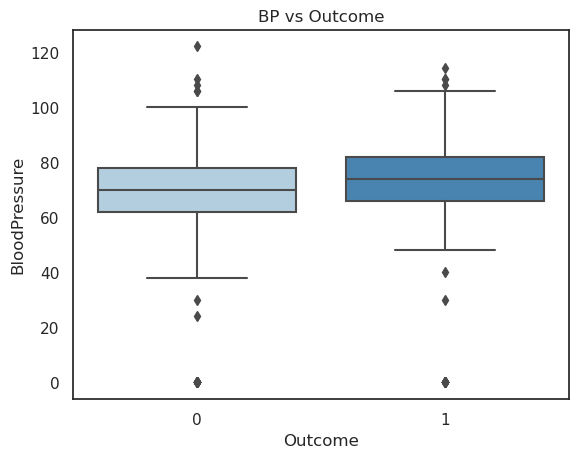

In [25]:
#Let's also check the effect of Blood Pressure on the Outcome.

sns.boxplot(x = 'Outcome', y = 'BloodPressure', data = df, palette = 'Blues')
plt.title('BP vs Outcome')
plt.show()

The median of the BloodPressure of diabetic people lies close to the 75th Percentile of non-diabetic people.

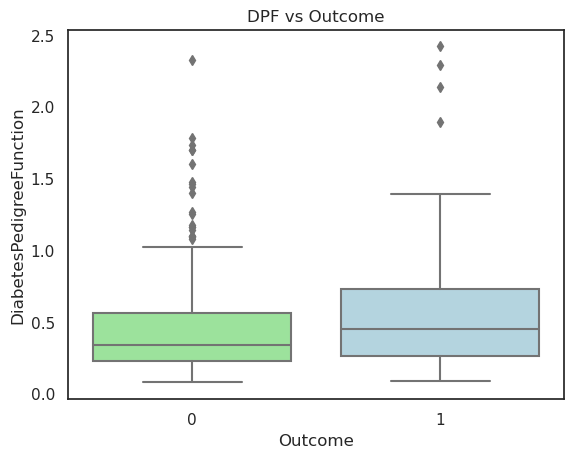

In [26]:
#One would also want to know the chances of getting diabetes, if it is common in the family. We can check that with the Diabetes Pedigree Functio

my_pal = {0: "lightgreen", 1: "lightblue"}
sns.boxplot(x = 'Outcome', y = 'DiabetesPedigreeFunction', data = df, palette = my_pal)
plt.title('DPF vs Outcome')
plt.show()

Quite a proportion of people having high DPF does not end up having Diabetes. But usually the diabetic people have DPF value close to 0.5 (50th Percentile)

### Gluscose Level

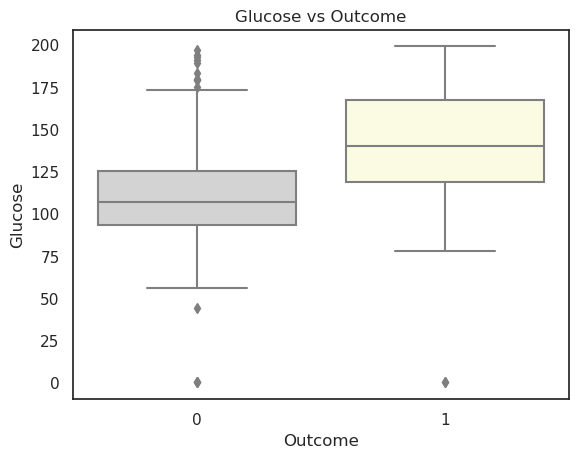

In [27]:
my_pal = {0: "lightgrey", 1: "lightyellow"}
sns.boxplot(x = 'Outcome', y = 'Glucose', data = df, palette = my_pal)
plt.title('Glucose vs Outcome')
plt.show()

Wow! the median of the Glucose level of Diabetic People is greater than the 75th Percentile of the glucose level of non-diabetic people. Therefore having a high glucose level does increase the chances of having diabetes.

### Body Mass Index

Body mass index (BMI) is a measure of body fat based on height and weight that applies to adult men and women. Does having a higher BMI leads to more chances of being diabetic? Let's check that out!

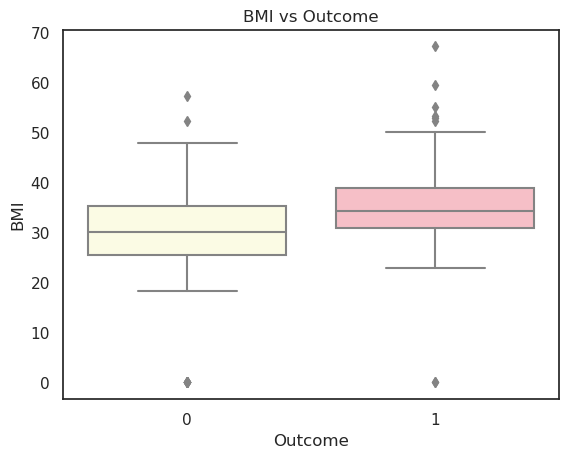

In [28]:
my_pal = {0: "lightyellow", 1: "lightpink"}
sns.boxplot(x = 'Outcome', y = 'BMI', data = df, palette = my_pal)
plt.title('BMI vs Outcome')
plt.show()

Indeed, the Median BMI of the Diabetic People is greater than the Median BMI of the Non-Diabetic people.

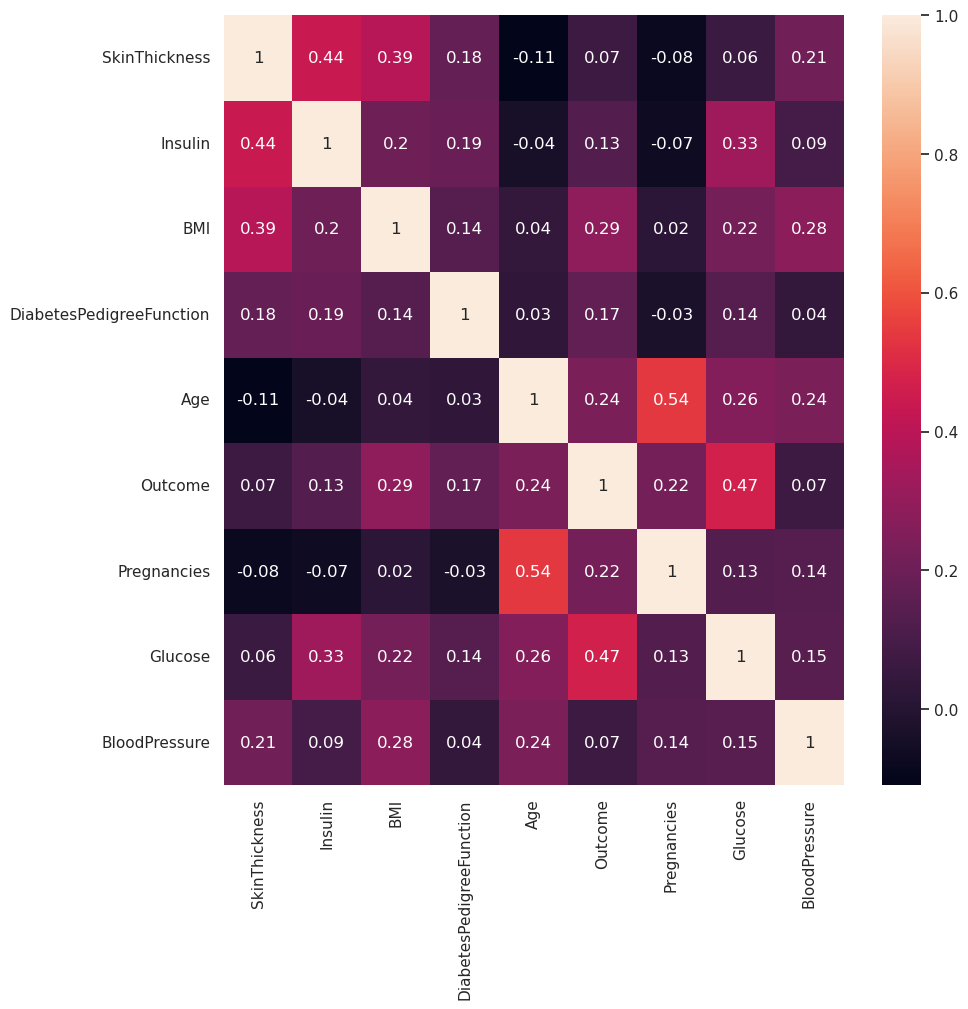

In [29]:
# Correlation matrix of the data

figure = plt.figure(figsize = (10, 10))
corr_matrix = df.corr().round(2)
sns.heatmap(data = corr_matrix, annot = True)
plt.savefig("corrheatmap.jpg")     #saving the image of this plot in the sagemaker console

# The less correlation, the better. More correlation means presence of duplication of features

Almost all predictors have weak linear correlations, which is indicative that most of them are more likely to have non-linear relationships.

However it is found that, the correlation between Pregnancies & Age is 54%, the correlation between SkinThickness & BMI is 39%, and the correlation between Insulin & SkinThickness is 44%.

So, the population is advised to be concerned about the above issues in order to minimise the chances of diabetes.

Further the analysis is mostly focused on the relationship between various diabetes features and the target feature which is diabetes outcome. This is because the classification purpose will be mostly interested in these types of correlation and their strengths in order for accurate predictions.

In [30]:
#Exporting the image of this plot directly into the s3 bucket

s3=boto3.resource('s3')
s3.meta.client.upload_file('corrheatmap.jpg',bucket_name,'corrheatmap.jpg')

### Building and Deploying Model

In [31]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://awsworkshop301/xgboost-as-a-built-in-algo/output


In [32]:
### Train Test split

train_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df))])
print(train_data.shape, test_data.shape)      #Not done as x_train y_train as we do in jupyter notebook
     

(537, 9) (231, 9)


* There are 537 rows and 9 columns in the train data.
* There are 231 rows and 9 columns in the test data.

While working in sagemaker the dependent feature that is 'Outcome' in this case should be the first column of the dataset.so, concatenating the train and test data in such a way that first column represents the dependent feature.

In [33]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os
pd.concat([train_data['Outcome'], train_data.drop(['Outcome'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')  #creating the path for the training data

In [34]:
# Test Data Into Buckets
pd.concat([test_data['Outcome'], test_data.drop(['Outcome'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')   #creating the path for the test data

### Building Models Xgboot- Inbuilt Algorithm

In [35]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.

container = get_image_uri(boto3.Session().region_name,    
                          'xgboost', 
                          repo_version='1.0-1')     #Pulling the inbuilt xgboost container or image from sagemaker with recent repo_version

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [36]:
# initialize hyperparameters
# The main purpose is to reduce the cost of model building

hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

In [37]:
# construct a SageMaker estimator that calls the xgboost-container
# shift +tab to undestand the estimator

estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', #GPU version for speed
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [38]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-08-11-15-17-091


2023-02-08 11:15:17 Starting - Starting the training job...
2023-02-08 11:15:37 Starting - Preparing the instances for training......
2023-02-08 11:16:26 Downloading - Downloading input data.....[2023-02-08 11:17:29.117 ip-10-0-183-110.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[11:17:29] 537x8 matrix with 4296 entries loaded from /opt/ml/input/data/train?format=csv&lab

The model has been created in the s3 bucket in the particular folder.

## Deploy Machine Learning Model As Endpoints

In [39]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')   #endpoints will be created

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-08-11-19-12-138
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-02-08-11-19-12-138
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-02-08-11-19-12-138


---------!

### Prediction on the Test Data

In [40]:
from sagemaker.predictor import csv_serializer  #data is a csv file
test_data_array = test_data.drop(['Outcome'], axis=1).values #load the data into an array
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


(231,)


In [41]:
#Creating the confusion matrix, code has been taken from the aws documentation

cm = pd.crosstab(index=test_data['Outcome'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "Negative", "Positive"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("Negative", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Positive", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 75.3%

Predicted      Negative       Positive
Observed
Negative       78% (129)    31% (20)
Positive        22% (37)     69% (45) 



### Deleting the endpoints

Once the prediction from the endpoint is done don't run it continuously because the charges will going on.
once the endpoint address is created it needs to be deleted to avoid any extra charges.

In [42]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)      #Deleteing the endpoint
bucket_to_delete=boto3.resource('s3').Bucket(bucket_name)        #Deleting the bucket
bucket_to_delete.objects.all().delete()

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-02-08-11-19-12-138


[{'ResponseMetadata': {'RequestId': '47R8QJNYSN9K1K1N',
   'HostId': 'JJg9XKLVlvhay+Q8IyNFqjMU6mKmUp1+Ee06wULwNxgwH+5pi5AORFyB1oSeU2fmCHJvL03Ls9U=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'JJg9XKLVlvhay+Q8IyNFqjMU6mKmUp1+Ee06wULwNxgwH+5pi5AORFyB1oSeU2fmCHJvL03Ls9U=',
    'x-amz-request-id': '47R8QJNYSN9K1K1N',
    'date': 'Wed, 08 Feb 2023 11:24:17 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'diabetes_second_data.csv'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2023-02-08-11-15-17-091/output/model.tar.gz'},
   {'Key': 'corrheatmap.jpg'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2023-02-08-11-15-17-091/debug-output/events/000000000010/000000000010_worker_0.tfevents'},
   {'Key': 'countplot.jpg'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2023-02-08-11-15-17-091/debug

The process of deleting endpoints and s3 bucket can also be done manually.